### Data Analysis of evSeq minION results 


In [68]:
# Import
import sys
sys.path.append("/home/emre/github_repo/MinION")
from minION.util import IO_processor
from minION import analyser
from minION import consensus

import importlib
importlib.reload(analyser)
importlib.reload(consensus)
importlib.reload(IO_processor)
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [69]:
# Import Data

ref_df = pd.read_csv('/home/emre/minION_results/JLK-I-027/07252022 - Jenni Kennemur/evSeqOutput/20220725-174936/OutputCounts/Bases_Coupled_Max.csv')

def rewrite_Plate_name(entry):
    entry = entry[-1]

    return int(entry)

def rewrite_Well_name(entry):
    num = int(entry[1:])
    new_entry = entry[0] + str(num)

    return new_entry

ref_df["Plate"] = ref_df["Plate"].apply(lambda x: rewrite_Plate_name(x))
ref_df["Well"] = ref_df["Well"].apply(lambda x: rewrite_Well_name(x))

In [70]:
ref_df = ref_df[ref_df["AlignmentFrequency"] > 0.7]

In [71]:
#demultiplexer_path =  "/home/emre/minION_results/MinION_RBC_0902723_sup/Demultiplex_cpp_70_short"
#demultiplexer_path = "/home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70"
demultiplexer_path = "/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/"
#template_fasta = Path("/home/emre/github_repo/MinION/minION/refseq/hetcpiii.fasta")
template_fasta = Path("/home/emre/tam-lqv.fasta")
barcodes = IO_processor.get_barcode_dict(Path(demultiplexer_path))
variant_df = analyser.get_variant_df_nn(demultiplexer_path,template_fasta, barcodes, consensus_folder_name="consensus" ,sequences=True, merge=True)
variant_template_df = analyser.template_df(barcodes, rowwise=False)

In [72]:
# Drop rows with count == NaN
variant_df = variant_df.dropna(subset=["count"])

In [73]:
file_path = Path("/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/RB03/NB11/consensus/consensus.fastq")
seq = IO_processor.read_fasta_file(file_path, score=True)["Sequence"]
template = IO_processor.read_fasta_file(template_fasta, score=False)["Sequence"]


In [74]:
variant_df[variant_df["Plate"] == 1]

,Plate,Well,Position,Variant,Quality-Score,Sequence,count
0,1,A1,NA,NA,NA,ATGCCGCAAATTCCCGGTTACACTTATGGAGATTCCGCCTTACCTC...,132.0
1,1,A2,NA,NA,NA,ATGCCGCAAATTCCCGGTTACACTTATGGAGATCCCGCCTTACCTC...,63.0
2,1,A3,[-],[#PARENT#],[-],ATGCCGCAAATTCCCGGTTACACTTATGGAGATCCCGCCTTACCTC...,145.0
3,1,A4,[-],[#PARENT#],[-],ATGCCGCAAATTCCCGGTTACACTTATGGAGATCCCGCCTTACCTC...,191.0
4,1,A5,[-],[#PARENT#],[-],ATGCCGCAAATTCCCGGTTACACTTATGGAGATCCCGCCTTACCTC...,56.0
5,1,A6,[-],[#PARENT#],[-],ATGCCGCAAATTCCCGGTTACACTTATGGAGATCCCGCCTTACCTC...,319.0
6,1,A7,"[199, 273, 410]","[C199T, T273A, C410T]","[54, 42, 50]",ATGCCGCAAATTCCCGGTTACACTTATGGAGATCCCGCCTTACCTC...,191.0
7,1,A8,"[56, 238]","[T56C, C238A]","[19, 24]",ATGCCGCAAATTCCCGGTTACACTTATGGAGATCCCGCCTTACCTC...,220.0
8,1,A9,[143],[T143C],[5],ATGCCGCAAATTCCCGGTTACACTTATGGAGATCCCGCCTTACCTC...,493.0
9,1,A10,[-],[#PARENT#],[-],ATGCCGCAAATTCCCGGTTACACTTATGGAGATCCCGCCTTACCTC...,142.0


In [50]:
# Rewrite variant_df for guppy basecaller

d_path = "/home/emre/minION_results/MinION_RBC_0902723_sup/demultiplex_45"

barcode_dicts = IO_processor.get_barcode_dict(Path(d_path))

variant_template_df = analyser.template_df(barcode_dicts)

variants = {"RBC": [], "FBC": [], "Position": [], "Variant": [], "Quality-Score": []}

variants["Sequence"] = []

template = analyser.get_template_sequence(template_fasta) # Reference sequence

n_counts = pd.DataFrame()
for barcode_id, barcode_dict in barcode_dicts.items():
    n_counts_rbc = analyser.read_summary_file(barcode_id)["barcode_arrangement"].value_counts().reset_index()
    rbc_basename = os.path.basename(barcode_id)
    n_counts_rbc = n_counts_rbc[n_counts_rbc["barcode_arrangement"] != "unclassified"]
    n_counts_rbc.rename(columns={"barcode_arrangement" : "FBC", "count" : "n_counts"}, inplace=True)
    n_counts_rbc["RBC"] = rbc_basename
    n_counts = pd.concat([n_counts, n_counts_rbc], axis=0)
    
for barcode_id, barcode_dict in barcode_dicts.items():

    rbc = os.path.basename(barcode_id)

    for front_barcode in barcode_dict:

        fbc = os.path.basename(front_barcode)

        front_barcode = os.path.join(front_barcode)

        fasta_file = os.path.join(front_barcode, "consensus" ,"consensus.fastq")

        # Check if consensus file exists
        if not os.path.exists(fasta_file):
            print(f"Consensus file in {front_barcode} does not exist, skipping {fbc}")
            continue

        try:
            consensus = analyser.get_consensus_sequence(fasta_file, True)
        
        except:
            print(f"Skipping {rbc}/{fbc}")
            print(consensus)
            continue

        
        variants["Sequence"].append(consensus["Sequence"][0])

        nn_variants = analyser.call_variant_nn(template, consensus["Sequence"][0], consensus["Quality-Score"][0])



        variants["RBC"].append(rbc)
        variants["FBC"].append(fbc)
        variants["Position"].append(nn_variants["Position"])
        variants["Variant"].append(nn_variants["Variant"])
        variants["Quality-Score"].append(nn_variants["Quality-Score"])



FileNotFoundError: Demultiplex folder '/home/emre/minION_results/MinION_RBC_0902723_sup/demultiplex_45' does not exist. Run minION to get the demultiplex folder.

In [51]:

variant_df =variant_df.merge(variant_template_df, on=["Plate", "Well"], how="right")


In [52]:
def transform(entry):
    # If the entry is either DEAD or PARENT, return empty lists
    if entry in ["#DEAD#", "#PARENT#"]:
        return [], [], []
    else:
        # Split the entry based on the underscore
        mutations = entry.split("_")
        parent_combo = []
        positions = []
        new_aa = []
        for mutation in mutations:
            # Append the first character to parent_combo, the middle to positions, and the last to new_aa

            #Skip if parent is equal to new_aa
            if mutation[0] == mutation[-1]:
                continue

            parent_combo.append(mutation[0])
            positions.append(mutation[1:-1])
            new_aa.append(mutation[-1])
        return parent_combo, positions, new_aa

def transform_ref(entry):

    parent_combo = []
    positions = []
    new_aa = []

    try:

        for variant in entry:

            if variant in ["#DEAD#", "#PARENT#"]:
                return ["-"], ["-"], ["-"] 
            
            else:
                parent_combo.append(variant[0])
                positions.append(variant[1:-1])
                new_aa.append(variant[-1])
        return parent_combo, positions, new_aa
    
    except:
        return ["NA"], ["NA"], ["NA"]
        
def substract_by_index(positions, index):
    new_positions = []
    for pos in positions:
        new_positions.append(str(int(pos) - index))
    
    return new_positions

ref_df[['ParentCombo', 'Positions', 'NewAA']] = ref_df['VariantCombo'].apply(lambda x: pd.Series(transform(x)))

ref_df['Positions'] = ref_df['Positions'].apply(lambda x: substract_by_index(x, 2722))
variant_df[['ParentCombo', 'Positions', 'NewAA']] = variant_df['Variant'].apply(lambda x: pd.Series(transform_ref(x)))



In [53]:
variant_df = variant_df.merge(ref_df[["Plate","Well"]], on=["Plate", "Well"], how="inner")

In [54]:
# Split Variant Combo
def split_variant_combo(entry):
    if entry in ["#DEAD#", "#PARENT#"]:
        return entry
    else:
        return entry.split("_")
    
def combine_variant_combo(entry):
    if entry in ["#DEAD#", "#PARENT#"]:
        return entry
    else:
        return "_".join(entry)

ref_df["VariantCombo_splitted"] = ref_df["VariantCombo"].apply(lambda x: split_variant_combo(x))

In [55]:
variants_list_ref = []

for variant in ref_df["VariantCombo_splitted"]:
    if variant in ["#DEAD#", "#PARENT#"]:
        variants_list_ref.append(variant)
    else:
        for var in variant:
            variants_list_ref.append(var)

variants_list_evSeq = []
evSeq_df_tmp = variant_df.dropna()
for variant in evSeq_df_tmp["Variant"]:
    if variant in ["#DEAD#", "#PARENT#"]:
        variants_list_evSeq.append(variant)

    elif variant == float("nan"):
        continue
    else:
        for var in variant:
            variants_list_evSeq.append(var)

In [56]:
variant_df = variant_df[~variant_df["Well"].isin(["A1", "A12", "H1", "H12"])]
ref_df = ref_df[~ref_df["Well"].isin(["A1", "A12", "H1", "H12"])]

In [57]:
ref_df

,IndexPlate,Plate,Well,VariantCombo,SimpleCombo,VariantsFound,AlignmentFrequency,WellSeqDepth,VariantSequence,Flags,ParentCombo,Positions,NewAA,VariantCombo_splitted
1,DI01,1,A2,#PARENT#,#PARENT#,0,0.996411,471,GACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCA...,#PARENT#,[],[],[],#PARENT#
5,DI01,1,A6,#PARENT#,#PARENT#,0,0.997644,272,GACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCA...,#PARENT#,[],[],[],#PARENT#
6,DI01,1,A7,#PARENT#,#PARENT#,0,0.997509,348,GACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCA...,#PARENT#,[],[],[],#PARENT#
7,DI01,1,A8,#PARENT#,#PARENT#,0,0.996623,567,GACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCA...,#PARENT#,[],[],[],#PARENT#
8,DI01,1,A9,#PARENT#,#PARENT#,0,0.996312,587,GACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCA...,#PARENT#,[],[],[],#PARENT#
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,DI03,3,H7,T2843A,A,1,0.977901,543,GACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCA...,Unexpected variation in forward primer seed.,[T],[121],[A],[T2843A]
283,DI03,3,H8,T2897C,C,1,0.977671,627,GACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCA...,Unexpected variation in forward primer seed.,[T],[175],[C],[T2897C]
284,DI03,3,H9,#PARENT#,#PARENT#,0,0.997327,406,GACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCA...,#PARENT#,[],[],[],#PARENT#
285,DI03,3,H10,T2749A_T2857A_T2872C,AAC,3,0.980769,260,GACATCCCGGGATAAGATTATGGGCGTGTCGAGAAGTCACCCATCA...,Unexpected variation in forward primer seed.,"[T, T, T]","[27, 135, 150]","[A, A, C]","[T2749A, T2857A, T2872C]"


In [58]:
# Num mutations

mut = {"Reference" : [], "Flongle" : []}

# Get unique entries
unique_entries_ref = list(set(variants_list_ref))
unique_entries_evSeq = list(set(variants_list_evSeq))

mut["Reference"].append(len(unique_entries_ref))
mut["Flongle"].append(len(unique_entries_evSeq))
mut = pd.DataFrame(mut)

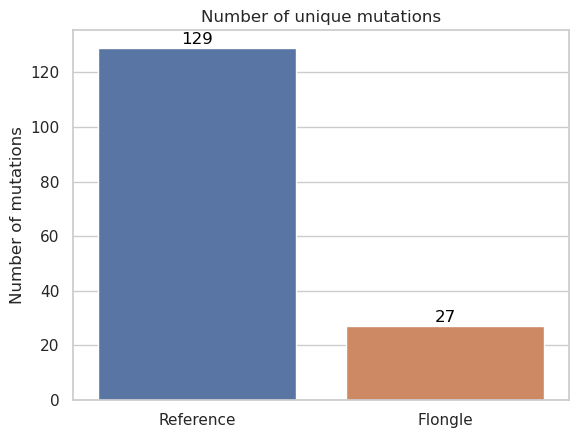

In [59]:
# Seaborne plot
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=mut.columns, y=mut.iloc[0])
ax.set_title("Number of unique mutations")
ax.set_ylabel("Number of mutations")
#ax.set_xlabel("Reference vs minION-guppy")
ax.text(0, mut.iloc[0,0] + 0.5, mut.iloc[0,0], ha='center', va='bottom', color='black')
ax.text(1, mut.iloc[0,1] + 0.5, mut.iloc[0,1], ha='center', va='bottom', color='black')

# Save plot
plt.savefig("/home/emre/github_repo/MinION/examples/Flongle_mutations.png")
plt.show()

In [ ]:
ref_df

In [ ]:
# Function to create VariantCombo
def create_variant_combo(row):
    variant_combos = []
    for parent, pos, aa in zip(row['ParentCombo'], row['Positions'], row['NewAA']):
        if parent and pos and aa:
            variant_combos.append(f"{parent}{pos}{aa}")
    return variant_combos if variant_combos else ["#PARENT#"] if not row['ParentCombo'] else ["#DEAD#"]

ref_df['VariantCombo'] = ref_df.apply(create_variant_combo, axis=1)



In [ ]:
ref_df = ref_df[['Plate', 'Well', 'VariantCombo']]

In [ ]:
ref_df = ref_df.rename(columns={"VariantCombo" : "VariantCombo_ref"})

In [ ]:
merged_df = pd.merge(ref_df, variant_df, on=['Plate', "Well"])


In [ ]:
def compare_mutations(row, mutation_only = True):

    if isinstance(row['Variant'], float):
        return pd.Series([0, 0, [], []], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])

    if mutation_only and row['VariantCombo_ref'] in [["#DEAD#"], ["#PARENT#"]]:
        return pd.Series([0, 0, [], []], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])

    
    mutations1 = set(row['VariantCombo_ref'])
    mutations2 = set(row['Variant'])
    
    correct_mutations = mutations1.intersection(mutations2)
    missed_mutations = mutations1.difference(mutations2)
    
    return pd.Series([len(correct_mutations), len(missed_mutations), list(correct_mutations), list(missed_mutations)], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])

def compare_only_Parent(row):

    if isinstance(row['Variant'], float):
        return pd.Series([0, 0, [], []], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])
    
    if row['VariantCombo_ref'] in [["#PARENT#"]]:
        mutations1 = set(row['VariantCombo_ref'])
        mutations2 = set(row['Variant'])
        
        correct_mutations = mutations1.intersection(mutations2)
        missed_mutations = mutations1.difference(mutations2)
        return pd.Series([len(correct_mutations), len(missed_mutations), list(correct_mutations), list(missed_mutations)], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])

    else:
         return pd.Series([0, 0, [], []], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])

def num_mutations(row):
    if isinstance(row['Variant'], float):
        return 0
    
    if row['VariantCombo_ref'] in [["#DEAD#"], ["#PARENT#"]]:
        return 0
    
    else:
        return len(row['VariantCombo_ref'])
    
def count_parent(row):
    if isinstance(row['Variant'], float):
        return 0
    
    if row['VariantCombo_ref'] in [["#PARENT#"]]:
        return 1
    
    else:
        return 0

def count_all(row):

    if isinstance(row['VariantCombo_ref'], float):
        return 0
    
    elif row['VariantCombo_ref'] in [["#PARENT#"]]:
        return 1
    
    else:
        return len(row['VariantCombo_ref'])
    
    




In [ ]:
df = merged_df.copy()
df[['Correct', 'Missed', 'CorrectMutations', 'MissedMutations']] = df.apply(compare_mutations,axis=1)
#Remove Well A1, A12, H1, H12
df = df[~df["Well"].isin(["A1", "A12", "H1", "H12"])]
accuracy = df["Correct"].sum() / df.apply(num_mutations, axis=1).sum()

In [ ]:
def find_max(entry):
    if isinstance(entry, list) and entry:
        if entry[0] == "#PARENT#":
            return "#PARENT#"
        else:
            # Assuming you want to find the max string in the list
            return max(entry)
    return "Invalid Entry"

result = df["Position"].apply(find_max).value_counts()
print(result)

In [ ]:
df[df["Missed"] > 0]

In [ ]:
accuracy

In [ ]:
identified = df["Correct"].sum() / df.apply(num_mutations, axis=1).sum()

In [ ]:
Accuracy = {"Method" : ["Mutation only", "Parent only", "All"], "Accuracy" : [0.970, 0.877, 0.876]}

In [ ]:
# Seaborne plot
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Method", y="Accuracy", data=Accuracy)
#ax.set_title("Mutation Calling accuracy minION")
ax.set_ylabel("Accuracy")
ax.text(0, Accuracy["Accuracy"][0] + 0.01, Accuracy["Accuracy"][0], ha='center', va='bottom', color='black')
ax.text(1, Accuracy["Accuracy"][1] + 0.01, Accuracy["Accuracy"][1], ha='center', va='bottom', color='black')
ax.text(2, Accuracy["Accuracy"][2] + 0.01, Accuracy["Accuracy"][2], ha='center', va='bottom', color='black')

# Save plot
plt.savefig("/home/emre/github_repo/MinION/examples/Flongle_cpp_70_accuracy.png")
plt.show()